# Lecture 9

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
# import tabulate

## Setup for SUSY Dataset

In [2]:
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawNames=["l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
FeatureNames=list(set(VarNames[1:]).difference(RawNames))

In [5]:
filename="/home/monicatnm/SUSY.csv"
df = pd.read_csv(filename, dtype='float64', names=VarNames)

In [6]:
df_sig=df[df.signal==1]
df_bkg=df[df.signal==0]

## FPR/TPR/ROC/AUC

In previous lecture, we wrote a helper function to compute FPR and TPR as function of selection. We are considering 4 different selections:
1. $x > x_c$
2. $x < x_c$
3. $|x - x_0| > x_c$
4. $|x - x_0| < x_c$

We so far have only implemented 1 in lecture:


In [7]:
def compute_rate(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist[::-1])[::-1] * (bins_[1]-bins_[0])
    return R,bins_

Let's remind ourselves how to use/plot this function:

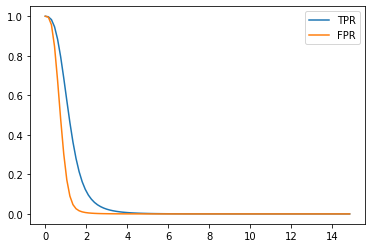

In [8]:
TPR,bins=compute_rate(df_sig["M_TR_2"])
FPR,bins=compute_rate(df_bkg["M_TR_2"],bins=bins)

plt.plot(bins[:-1],TPR,label="TPR")
plt.plot(bins[:-1],FPR,label="FPR")
plt.legend()


### ROC
Creating a ROC curve is as simple as ploting FPR vs TPR. We'll add a line from (0,0) to (1,1) to represent a bad ROC curve. 

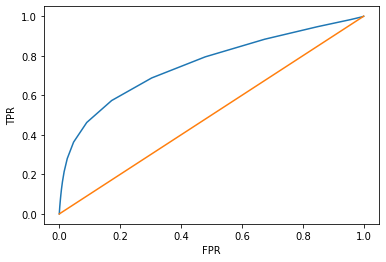

In [9]:
plt.plot(FPR,TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0,1],[0,1])


Note that while the curve looks smooth, it's really not:

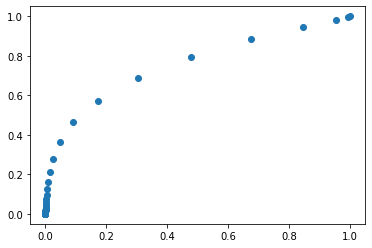

In [10]:
plt.scatter(FPR,TPR)

And it's drawn from top right to bottom left:

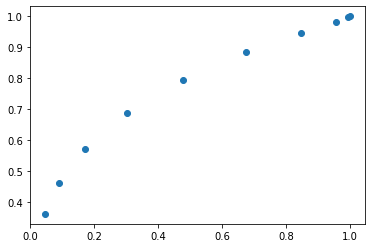

In [11]:
plt.scatter(FPR[:10],TPR[:10])

### AUC

The Area Under the Curve (AUC) is a reasonable assessment of how good a variable is in separating the two classes (signal/background). We can compute it using rectangles:

In [12]:
AUC = 0.
for k in range(len(FPR)-1):
    AUC+= (FPR[k] - FPR[k + 1]) * TPR[k]
AUC

0.7965380678785561

But the rectangles aren't very precise. In this case, do they under or over estimate the area?

Fairly easy to use trapezoids instead. The equation is:

$$
\int_a^b f(x) dx = \sum^N_{k=1} \frac{f(x_{k-1}) + f(x_k)}{2} \Delta x_k
$$

In [13]:
AUC = 0.
for k in range(len(FPR)-1):
    AUC += (FPR[k] - FPR[k + 1]) * (TPR[k]+TPR[k+1])/2.
AUC

0.7550550062412151

Instead of looping, we can tensor operations with `numpy`. First we need to know the size of the vector: 

In [14]:
FPR.shape

(100,)

We can compute the difference easily:

In [15]:
FPR[0:99]-FPR[1:100]

array([4.48865337e-03, 3.87844134e-02, 1.08809102e-01, 1.73048391e-01,
       1.95319102e-01, 1.75988838e-01, 1.31573145e-01, 8.17595639e-02,
       4.32487320e-02, 2.07744937e-02, 1.02891705e-02, 5.54279006e-03,
       3.28555859e-03, 2.02273307e-03, 1.35795222e-03, 9.43892939e-04,
       6.66993096e-04, 4.95543793e-04, 3.34049610e-04, 2.47034480e-04,
       1.93940502e-04, 1.60388058e-04, 1.34578485e-04, 9.14396285e-05,
       7.33729277e-05, 6.19429741e-05, 4.97756042e-05, 4.09266079e-05,
       3.13401952e-05, 2.47034480e-05, 2.13850744e-05, 1.58544517e-05,
       1.91728253e-05, 1.36422026e-05, 1.14299536e-05, 1.14299536e-05,
       1.03238290e-05, 8.11157994e-06, 5.53062269e-06, 4.79320633e-06,
       3.31837361e-06, 3.68708179e-06, 4.79320633e-06, 3.31837361e-06,
       1.10612454e-06, 2.94966543e-06, 2.94966543e-06, 3.68708179e-07,
       1.10612454e-06, 7.37416359e-07, 2.21224908e-06, 1.10612454e-06,
       1.10612454e-06, 1.10612454e-06, 3.68708179e-07, 7.37416359e-07,
      

Finally the AUC:

In [16]:
np.sum((FPR[0:99]-FPR[1:100]) * (TPR[0:99]+TPR[1:100])/2)

0.755055006241215

Now lets wrap it up in a function:

In [17]:
def AUC(TPR,FPR):
    n = FPR.shape[0]
    return np.sum((FPR[0:n-1]-FPR[1:]) * (TPR[0:n-1]+TPR[1:])/2)

In [18]:
AUC(TPR,FPR)

0.755055006241215

## Other Selections

Note that this function only works for the first possible selection criteria:

1. $x > x_c$
2. $x < x_c$
3. $|x - x_0| > x_c$
4. $|x - x_0| < x_c$

The second selection is easy:

In [19]:
def compute_rate_1(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist[::-1])[::-1] * (bins_[1]-bins_[0])
    return R,bins_

def compute_rate_2(d,bins=100):
    hist,bins_=np.histogram(d,bins=bins,density=True)
    R = np.cumsum(hist) * (bins_[1]-bins_[0])
    return R,bins_

Let's workout how to do the other ones:

(array([ 53127., 126274., 229160., 333589., 401544., 401106., 334161.,
        228592., 127129.,  53145.]),
 array([-2.10291862e+00, -1.68246710e+00, -1.26201558e+00, -8.41564059e-01,
        -4.21112537e-01, -6.61015511e-04,  4.19790506e-01,  8.40242028e-01,
         1.26069355e+00,  1.68114507e+00,  2.10159659e+00]),
 <BarContainer object of 10 artists>)

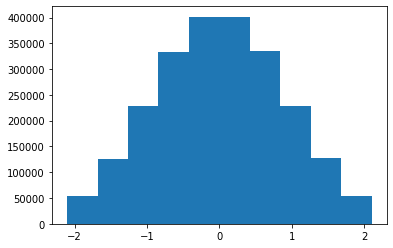

In [20]:
plt.hist(df_sig["l_1_eta"])

(array([329754., 335882., 338251., 316553., 295960., 249267., 188562.,
        125862.,  72500.,  35236.]),
 array([1.81198120e-06, 3.20293493e-01, 6.40585175e-01, 9.60876856e-01,
        1.28116854e+00, 1.60146022e+00, 1.92175190e+00, 2.24204358e+00,
        2.56233526e+00, 2.88262694e+00, 3.20291862e+00]),
 <BarContainer object of 10 artists>)

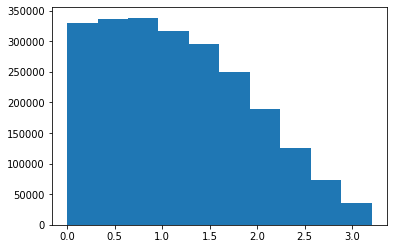

In [21]:
plt.hist(np.abs(df_sig["l_1_eta"]-1.1))

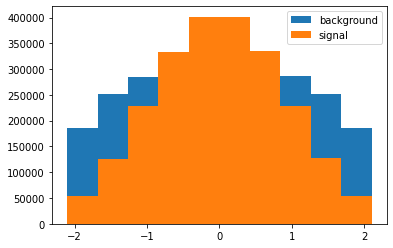

In [22]:
plt.hist(df_bkg["l_1_eta"],label="background")
plt.hist(df_sig["l_1_eta"],label="signal")
plt.legend()

In [23]:
def compute_rate_3(d,x_0=0.,bins=100):
    hist,bins_=np.histogram(np.abs(d-x_0),bins=bins,density=True)
    R = np.cumsum(hist[::-1])[::-1] * (bins_[1]-bins_[0])
    return R,bins_

def compute_rate_4(d,x_0=0.,bins=100):
    hist,bins_=np.histogram(np.abs(d-x_0),bins=bins,density=True)
    R = np.cumsum(hist) * (bins_[1]-bins_[0])
    return R,bins_


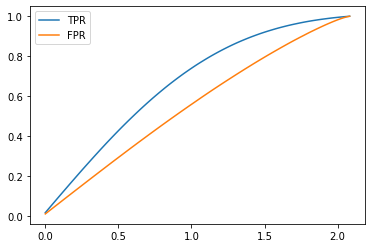

In [24]:
TPR,bins=compute_rate_4(df_sig["l_1_eta"])
FPR,bins=compute_rate_4(df_bkg["l_1_eta"],bins=bins)

plt.plot(bins[:-1],TPR,label="TPR")
plt.plot(bins[:-1],FPR,label="FPR")
plt.legend()



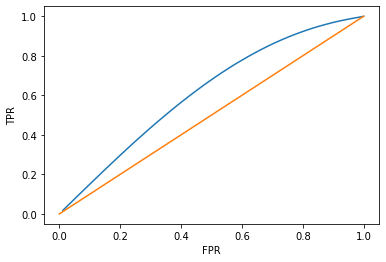

In [25]:
plt.plot(FPR,TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot([0,1],[0,1])

## Linear Discriminant

From lab 4:

Compute the between-class $\bf{S}_B$ and within-class $\bf{S}_W$ covariance matrices defined as:

$$
\bf{S}_B = (\bf{m_2}-\bf{m_1})(\bf{m_2}-\bf{m_1})^T \\
$$
$$
\bf{S}_W = \sum_{i=1,2} \sum_{n=1}^{l_i} (\bf{x}_n^i - \bf{m}_i) (\bf{x}_n^i - \bf{m}_i)^T
$$

where $\bf{m_i}$ are the vectors containing the means for category 1 and 2, here defined as signal and background. Here $\bf{x}_n^i$ is the vector containing the observables for the $n$th example event in category $i$.

Compute the linear coefficients $\bf{w} = \bf{S_W}^{-1}(\bf{m_2}-\bf{m_1})$. Compare the histogram of the distribution of $F_n^i=\bf{w}^T\bf{x}_n^i$ for the two categories.



In [26]:
# Wrong
np.mean(np.array(df_sig))

0.7603279965519885

In [27]:
df_sig.shape

(2287827, 19)

In [28]:
df_sig

,signal,l_1_pT,l_1_eta,l_1_phi,l_2_pT,l_2_eta,l_2_phi,MET,MET_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
8,1.0,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999986,1.0,0.951119,-1.025120,0.735755,1.072442,-1.268414,-1.365378,0.496042,-1.378751,0.027446,0.241199,0.841212,0.726010,0.765865,0.000000,0.816827,0.300119,0.758559,0.259673
4999988,1.0,2.039801,0.851302,0.125229,0.934144,0.551678,-0.811299,1.602762,-0.852513,0.209035,0.412390,1.370954,1.584090,1.025354,0.202440,1.102830,0.605197,0.739403,0.612186
4999991,1.0,1.031701,0.648011,-1.616710,0.532912,1.663047,-1.243807,0.706740,0.189915,0.433557,-0.393302,0.809631,1.087218,1.191645,1.972363,0.698013,1.564201,0.035361,0.504437
4999995,1.0,0.853325,-0.961783,-1.487277,0.678190,0.493580,1.647969,1.843867,0.276954,1.025105,-1.486535,0.892879,1.684429,1.674084,3.366298,1.046707,2.646649,1.389226,0.364599


In [29]:
df_sig_0 = df_sig.drop("signal",axis=1)
df_bkg_0 = df_bkg.drop("signal",axis=1)

df_sig_0

,l_1_pT,l_1_eta,l_1_phi,l_2_pT,l_2_eta,l_2_phi,MET,MET_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
1,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
8,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999986,0.951119,-1.025120,0.735755,1.072442,-1.268414,-1.365378,0.496042,-1.378751,0.027446,0.241199,0.841212,0.726010,0.765865,0.000000,0.816827,0.300119,0.758559,0.259673
4999988,2.039801,0.851302,0.125229,0.934144,0.551678,-0.811299,1.602762,-0.852513,0.209035,0.412390,1.370954,1.584090,1.025354,0.202440,1.102830,0.605197,0.739403,0.612186
4999991,1.031701,0.648011,-1.616710,0.532912,1.663047,-1.243807,0.706740,0.189915,0.433557,-0.393302,0.809631,1.087218,1.191645,1.972363,0.698013,1.564201,0.035361,0.504437
4999995,0.853325,-0.961783,-1.487277,0.678190,0.493580,1.647969,1.843867,0.276954,1.025105,-1.486535,0.892879,1.684429,1.674084,3.366298,1.046707,2.646649,1.389226,0.364599


In [30]:
m_s= np.mean(df_sig_0,axis=0)
m_s

l_1_pT          1.290233
l_1_eta        -0.000336
l_1_phi        -0.000553
l_2_pT          1.138185
l_2_eta         0.000378
l_2_phi        -0.000128
MET             1.417029
MET_phi         0.000155
MET_rel         1.275509
axial_MET       0.084007
M_R             1.182889
M_TR_2          1.268996
R               1.057301
MT2             1.074723
S_R             1.174697
M_Delta_R       1.185596
dPhi_r_b        1.014991
cos_theta_r1    0.282560
dtype: float64

In [31]:
m_s= np.mean(df_sig_0,axis=0)
m_b= np.mean(df_bkg_0,axis=0)

delta = m_s-m_b
delta

l_1_pT          0.534471
l_1_eta        -0.000660
l_1_phi        -0.000928
l_2_pT          0.255800
l_2_eta         0.000765
l_2_phi        -0.000199
MET             0.768856
MET_phi         0.000220
MET_rel         0.505262
axial_MET       0.154960
M_R             0.336500
M_TR_2          0.495985
R               0.105791
MT2             0.136978
S_R             0.321855
M_Delta_R       0.341800
dPhi_r_b        0.028585
cos_theta_r1    0.106272
dtype: float64

In [32]:
delta.shape

(18,)

In [33]:
delta.transpose().shape

(18,)

In [34]:
np.matrix(delta).shape

(1, 18)

In [35]:
np.matrix(delta).transpose().shape

(18, 1)

In [36]:
delta=np.matrix(m_s-m_b).transpose()

In [37]:
S_B= delta*delta.transpose()
S_B

matrix([[ 2.85659103e-01, -3.52809644e-04, -4.96156489e-04,
          1.36717519e-01,  4.08806287e-04, -1.06310408e-04,
          4.10931386e-01,  1.17828594e-04,  2.70047689e-01,
          8.28218385e-02,  1.79849669e-01,  2.65089747e-01,
          5.65419449e-02,  7.32109964e-02,  1.72022353e-01,
          1.82682327e-01,  1.52779431e-02,  5.67995029e-02],
        [-3.52809644e-04,  4.35745417e-07,  6.12789134e-07,
         -1.68856020e-04, -5.04905320e-07,  1.31301040e-07,
         -5.07529970e-04, -1.45526832e-07, -3.33528420e-04,
         -1.02290958e-04, -2.22127344e-04, -3.27405003e-04,
         -6.98333898e-05, -9.04208734e-05, -2.12460043e-04,
         -2.25625882e-04, -1.88693643e-05, -7.01514925e-05],
        [-4.96156489e-04,  6.12789134e-07,  8.61765858e-07,
         -2.37462358e-04, -7.10048762e-07,  1.84648760e-07,
         -7.13739809e-04, -2.04654502e-07, -4.69041288e-04,
         -1.43851858e-04, -3.12377864e-04, -4.60429922e-04,
         -9.82067528e-05, -1.27158948e

In [38]:
S_B.shape

(18, 18)

Now lets compute $S_W$. Start with:

$$ (\bf{x}_n^i - \bf{m}_i) $$

In [39]:
df_sig_0-m_s

,l_1_pT,l_1_eta,l_1_phi,l_2_pT,l_2_eta,l_2_phi,MET,MET_phi,MET_rel,axial_MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos_theta_r1
1,0.377740,0.064527,-1.224618,-0.632083,-0.339317,1.672670,2.058436,-1.219291,-1.262554,3.691167,-0.136912,-0.700944,-0.575372,-1.074723,-0.726287,-0.980241,0.306903,0.095024
2,-0.845393,-0.133962,-0.709418,-0.686466,-1.614249,-0.768533,-0.197111,0.503871,0.555739,-0.515392,-0.656606,-0.327482,0.530234,0.949585,-0.571200,0.376778,0.120464,-0.101650
3,-0.908977,-0.975809,0.693706,-0.689226,0.891375,-0.677201,0.616031,1.532886,1.770751,-1.089292,-0.613503,-0.253784,0.524916,0.477191,-0.413482,0.529867,0.477266,-0.191841
4,0.019763,-0.689753,-0.675706,0.451098,-0.693703,0.623035,-0.329467,-0.381897,-0.686304,1.281472,-0.003594,-0.300777,-0.328738,-1.074723,-0.091540,-1.142167,0.139863,-0.187701
8,0.822579,0.743319,-0.329986,-0.332932,-0.029265,-1.446551,0.882917,1.450274,1.713602,-1.978777,0.262235,1.279171,0.507420,1.318909,0.379869,0.962872,0.164126,0.405497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999986,-0.339115,-1.024784,0.736309,-0.065743,-1.268792,-1.365250,-0.920987,-1.378906,-1.248063,0.157192,-0.341678,-0.542985,-0.291436,-1.074723,-0.357870,-0.885477,-0.256432,-0.022887
4999988,0.749568,0.851638,0.125782,-0.204041,0.551300,-0.811171,0.185733,-0.852668,-1.066474,0.328383,0.188064,0.315094,-0.031946,-0.872283,-0.071867,-0.580399,-0.275588,0.329626
4999991,-0.258532,0.648347,-1.616156,-0.605273,1.662669,-1.243679,-0.710289,0.189760,-0.841952,-0.477309,-0.373259,-0.181777,0.134344,0.897640,-0.476684,0.378604,-0.979630,0.221877
4999995,-0.436908,-0.961446,-1.486724,-0.459995,0.493202,1.648097,0.426838,0.276799,-0.250404,-1.570542,-0.290010,0.415433,0.616784,2.291575,-0.127990,1.461053,0.374235,0.082039


In [40]:
delta_s=np.matrix(df_sig_0-m_s).transpose()

In [41]:
delta_s.shape

(18, 2287827)

In [42]:
S_W_s= delta_s*delta_s.transpose()

In [43]:
S_W_s.shape

(18, 18)

In [44]:
delta_b=np.matrix(df_bkg_0-m_b).transpose()
S_W_b= delta_b*delta_b.transpose()

In [45]:
S_W_b.shape

(18, 18)

In [46]:
S_W=S_W_s-S_W_b

Lastly compute:
$\bf{w} = \bf{S_W}^{-1}(\bf{m_2}-\bf{m_1})$

In [47]:
S_W_inv = np.linalg.inv(S_W)

In [48]:
w = S_W_inv * np.matrix(m_b - m_s).transpose()

In [49]:
w

matrix([[-9.25526420e-06],
        [ 2.47737618e-09],
        [-3.10334483e-07],
        [-9.76896948e-06],
        [ 1.65352718e-08],
        [-3.58541809e-07],
        [ 5.97750662e-07],
        [-3.23916552e-07],
        [-4.70809383e-08],
        [-6.97586660e-07],
        [ 2.01277402e-05],
        [ 1.97182757e-05],
        [-2.28187653e-06],
        [ 1.97599222e-06],
        [-1.97163605e-05],
        [-7.41430191e-06],
        [ 2.08695678e-06],
        [-4.27163873e-05]])

In [50]:
output_s=np.matrix(df_sig_0)*w
output_b=np.matrix(df_bkg_0)*w

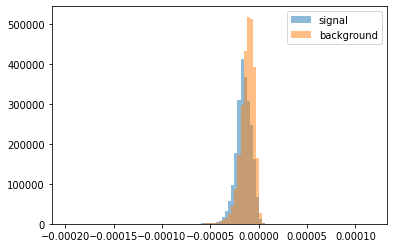

In [51]:
h_s,bins,_=plt.hist(output_s,label="signal",alpha=0.5,bins=100)
h_b,bins,_=plt.hist(output_b,bins=bins,alpha=0.5,label="background")
plt.legend()